In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
## MNIST IMAGE -> TENSOR

In [5]:
transform = transforms.ToTensor()

In [6]:
train_data = datasets.MNIST(root='../PYTORCH_NOTEBOOKS/Data',train=True, download=True,transform = transform)

In [7]:
test_data = datasets.MNIST(root='../PYTORCH_NOTEBOOKS/Data',train=False, download=True,transform = transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../PYTORCH_NOTEBOOKS/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../PYTORCH_NOTEBOOKS/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
type(train_data[0])

tuple

In [12]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [13]:
image, label = train_data[0] 

In [14]:
image.shape

torch.Size([1, 28, 28])

In [15]:
label

5

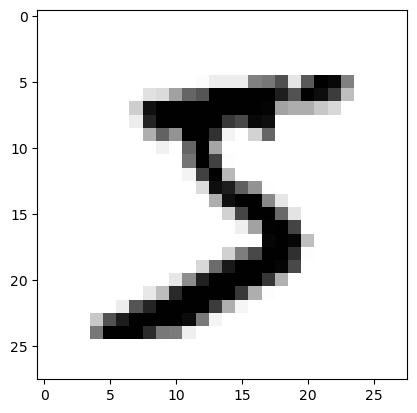

In [19]:
plt.imshow(image.reshape((28,28)), cmap ='gist_yarg')

In [40]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size =100, shuffle=True) ##generalize data (0,1) by shuffle

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [22]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # FORMATTING

In [23]:
# FIRST BATCH
for images, labels in train_loader:
    # 60,000 / 100 -> 60 times
    break

In [24]:
images.shape ## 100 images, 1 grayscale(1 color channel), 28x28

torch.Size([100, 1, 28, 28])

In [25]:
labels.shape

torch.Size([100])

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


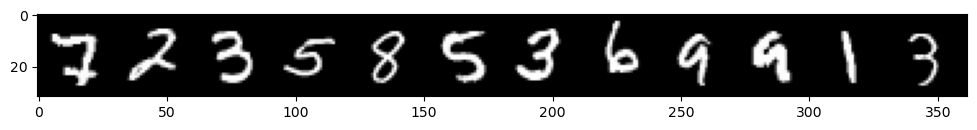

In [31]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(12,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [32]:
class MultilayerPerceptron(nn.Module):

    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()

        self.fc1= nn.Linear(in_sz, layers[0])
        self.fc2= nn.Linear(layers[0],layers[1])
        self.fc3= nn.Linear(layers[1],out_sz)

    def forward(self,X):

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim=1) # MULTI CLASS CLASSIFICATION

In [33]:
torch.manual_seed(101)
model = MultilayerPerceptron()
gpumodel = MultilayerPerceptron().cuda
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
# ANN --> CNN
for param in model.parameters():
    print(param.numel()) ## number of elements

94080
120
10080
84
840
10


In [35]:
# 105000, 214 parameters -> use more efficient CNN
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)

In [36]:
#flatten the datas
images.shape # --> [100,784] 100 images (28*28) make to 1 dimension (784)
images.view(100,-1).shape # combine the single dim

torch.Size([100, 784])

In [38]:
import time
start_time = time.time()

## Training

epochs =10

# Trackers
train_losses = []
test_losses =[]
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        
        # 10 Neurons
        
        b +=1
        y_pred = model(X_train.view(100,-1)) ## flatten
        loss = criterion(y_pred, y_train)


        predicted = torch.max(y_pred.data,1)[1] # [0.1,0.0,...0.8] get the best probability
        # and get the real value in that index (flattened(1)) into predicted
        batch_corr = (predicted == y_train).sum() # sum of how many correct count
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            accuracy = 100* trn_corr.item() /(b*100)
            print(f'Epoch {i} batch {b} loss {loss.item()} accuracy: {accuracy}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)

    
    
    
    with torch.no_grad(): ## no backprop & gradient

        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test.view(500,-1))

            predicted = torch.max(y_val,1)[1]
            tst_corr += (predicted == y_test).sum() ##(batch_corr)

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


total_time = time.time() -start_time
print(f'Duration :{total_time/60} mins')

Epoch 0 batch 200 loss 0.02625022456049919 accuracy: 99.52
Epoch 0 batch 400 loss 0.027381762862205505 accuracy: 99.4675
Epoch 0 batch 600 loss 0.0024918208364397287 accuracy: 99.32666666666667
Epoch 1 batch 200 loss 0.00613812729716301 accuracy: 99.45
Epoch 1 batch 400 loss 0.0036446445155888796 accuracy: 99.465
Epoch 1 batch 600 loss 0.06537120044231415 accuracy: 99.44666666666667
Epoch 2 batch 200 loss 0.0025069108232855797 accuracy: 99.615
Epoch 2 batch 400 loss 0.0066865249536931515 accuracy: 99.555
Epoch 2 batch 600 loss 0.017204785719513893 accuracy: 99.58833333333334
Epoch 3 batch 200 loss 0.009508511051535606 accuracy: 99.72
Epoch 3 batch 400 loss 0.00460472097620368 accuracy: 99.5875
Epoch 3 batch 600 loss 0.005691993050277233 accuracy: 99.53666666666666
Epoch 4 batch 200 loss 0.006959476042538881 accuracy: 99.745
Epoch 4 batch 400 loss 0.003238822566345334 accuracy: 99.7175
Epoch 4 batch 600 loss 0.0006982905906625092 accuracy: 99.68333333333334
Epoch 5 batch 200 loss 0.0036